In [96]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from interaction_inference import dataset, optimization

## Dataset (PNAS Smart-seq-total paper)

Load dataset of single genes

In [97]:
data_FIB = pd.read_csv("./Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)

## Capture efficiency

Estimate capture efficiency per cell from the full dataset of genes:
- set a mean value <$\beta$>
- compute the total counts per cell / total counts across all cells
- renormalize to have mean <$\beta$>, giving capture efficiency $\beta_{j}$ per cell

In [98]:
# mean beta
beta_mean = 0.1

# total counts per cell
total_per_cell = data_FIB.sum(axis='rows')

# total counts across all cells
total_overall = total_per_cell.sum()

# count proportions per cell (sum = 1)
count_proportion = (total_per_cell / total_overall).to_numpy()

# number of cells
n = count_proportion.size

# re-normalize
beta = count_proportion * beta_mean * n

# clamp values outside [0, 1]
if (beta >= 1).size > 0:
    beta[beta >= 1] = beta[beta < 1].max()
if (beta <= 0).size > 0:
    beta[beta <= 0] = beta[beta > 0].min()

In [99]:
# set mean beta
MeanBETA = 0.1

#xx<-Matrix::colSums(Data)
xx = data_FIB.sum(axis='rows')

#Normcount <- t_sp(t_sp(Data)/xx) * mean(xx)
# Normcount <- Matrix::t(Matrix::t(Data)/xx) * mean(xx)
Normcount = (data_FIB / xx) * np.mean(xx) # sum = mean(xx) per column

#means <- Matrix::rowMeans(Normcount)
means = Normcount.mean(axis='columns')

#lmeans <- log(means)
lmean = np.log(means)

#med <- apply(log(Normcount + 1), 1, function(x) {
#    median(x)
#})
med = np.log(Normcount + 1).median(axis=1)

#mad <- apply(log(Normcount + 1), 1, function(x) {
#    mad(x)
#})
mad = np.log(Normcount + 1).apply(lambda row: (row - row.median()).abs().median(), axis=1)

#bound <- med + 3 * mad
bound = med + 3*mad

#maxlogGene <- apply(log(Normcount + 1), 1, max)
maxlogGene = np.log(Normcount + 1).max(axis=1)

#ind <- which(maxlogGene < bound)
ind = maxlogGene < bound

#dropout = apply(Data, 1, function(x) {
#    length(which(x == 0))/length(x)
#})
dropout = data_FIB.apply(lambda row: (row == 0).sum() / row.size, axis=1)


#Select_ind <- intersect(ind, which(dropout < 0.35))
Select_ind = ind & (dropout < 0.35)

# Selected_genes <- rownames(Data)[Select_ind]
Selected_genes = list(Select_ind.index)

#temppp <- Matrix::colSums(Data[Select_ind, ])
temppp = data_FIB[Select_ind].sum(axis=0)

#BETA <- temppp/mean(temppp) * MeanBETA
BETA = (temppp / temppp.mean()) * MeanBETA

#if (length(which(BETA >= 1)) > 0) {
#    BETA[BETA >= 1] = max(BETA[BETA < 1])
#}
#if (length(which(BETA <= 0)) > 0) {
#    BETA[BETA <= 0] = min(BETA[BETA > 0])
#}
if (BETA >= 1).size > 0:
    BETA[BETA >= 1] = BETA[BETA < 1].max()
if (BETA <= 0).size > 0:
    BETA[BETA <= 0] = BETA[BETA > 0].min()

#names(BETA) <- colnames(Data)

#return(list(BETA = BETA, Selected_genes = Selected_genes))
BETA = BETA.to_numpy()

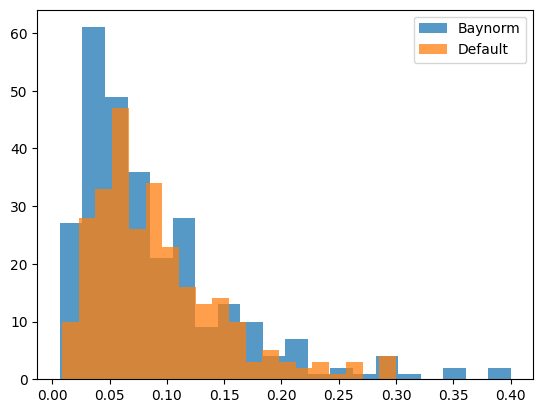

In [100]:
plt.hist(BETA, bins=20, alpha=0.75, label="Baynorm");
plt.hist(beta, bins=20, alpha=0.75, label="Default");
plt.legend()

## Construct dataset of pairs

Avoid repeating pairs as symmetric

In [133]:
# size
genes = 100
gene_pairs = (genes * (genes - 1) // 2) + genes
cells = data_FIB.shape[1]

# construct paired count dataframe
counts_df = pd.DataFrame(
    index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
    columns = [f"Cell-{j}" for j in range(cells)]
)

# fill with pairs
k = 0
for i in range(genes):
    gene_i = data_FIB.iloc[i]
    for j in range(genes):
        if j > i:
            break
        gene_j = data_FIB.iloc[j]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[k] = gene_pair_ij
        k += 1

# construct object
dataset_FIB = dataset.Dataset("dataset_FIB")
dataset_FIB.count_dataset = counts_df
dataset_FIB.cells = cells
dataset_FIB.gene_pairs = gene_pairs

# settings
dataset_FIB.thresh_OB = 3
dataset_FIB.threshM_OB = 3

# set capture
dataset_FIB.beta = BETA

### Moment optimization

In [134]:
# memory settings
dataset_FIB.resamples = 1000

In [135]:
dataset_FIB.compute_moments(tqdm_disable=False)

  0%|          | 0/5050 [00:00<?, ?it/s]

100%|██████████| 5050/5050 [02:04<00:00, 40.53it/s]


In [136]:
# optimization analysis
moment_FIB = optimization.Optimization(
    dataset_FIB,
    [
        "dummy_moment"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

100%|██████████| 5050/5050 [01:35<00:00, 52.74it/s]


In [137]:
moment_array = np.zeros((genes, genes))
k = 0
for i in range(genes):
    for j in range(genes):
        # ignore above diagonal
        if j > i:
            break
        else:
            if moment_FIB.result_dict[k]['status'] == "INFEASIBLE":
                moment_array[i, j] = 1
            k += 1

# fill above diagonal by symmetry
for i in range(genes):
    for j in range(genes):
        if j > i:
            moment_array[i, j] = moment_array[j, i]

# optional remove lower triangle + diagonal (as symmetric + irrelevant diag)
#for i in range(genes):
#    for j in range(genes):
#        if j <= i:
#            moment_array[i, j] = 0.5

Text(0.0, 110.0, 'Optimization using moment CIs to test independence         \nBlue: feasible, independent pair          \nRed: infeasible, interacting pair')

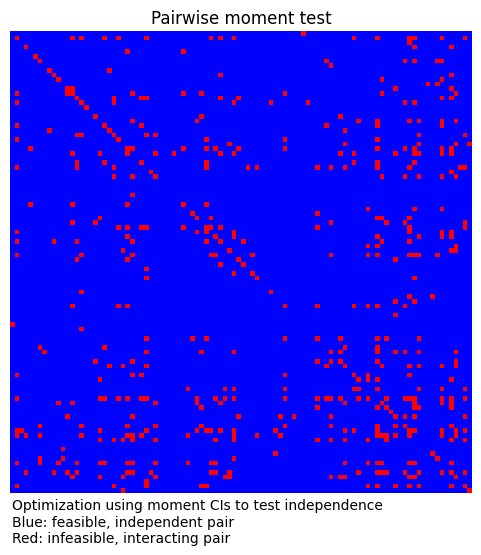

In [138]:
fig, axs = plt.subplots(figsize=(6, 6))
cmap = LinearSegmentedColormap.from_list('br', [(0, "b"), (0.5, "w"), (1, "r")], N=256)
vmin, vmax = 0, 1
img = axs.imshow(moment_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Pairwise moment test")
plt.axis('off')
plt.text(0.0, 110.0, "Optimization using moment CIs to test independence\
         \nBlue: feasible, independent pair \
         \nRed: infeasible, interacting pair")
#cbar = plt.colorbar(img, ax=axs)
#cbar.set_label("p-value")

#### Correlations of moment-infeasible pairs

In [228]:
import scipy

moment_blackout_array = np.zeros((genes, genes))
k = 0
for i in range(genes):
    for j in range(genes):
        if j > i:
            pass
        else:
            if moment_array[i, j] == 1:
                # change infeasible pairs value to correlation

                # get sample
                sample = moment_FIB.dataset.count_dataset.loc[f'Gene-pair-{k}']
                x1_sample = [x[0] for x in sample]
                x2_sample = [x[1] for x in sample]

                # correlation test
                pearson = scipy.stats.pearsonr(x1_sample, x2_sample, alternative='less')

                # store statistic
                moment_blackout_array[i, j] = float(pearson.statistic)

            else:
                # set feasible pairs to 0
                moment_blackout_array[i, j] = None
            k += 1

# fill above diagonal by symmetry
for i in range(genes):
    for j in range(genes):
        if j > i:
            moment_blackout_array[i, j] = moment_blackout_array[j, i]

# optional delete diagonal
for k in range(genes):
    moment_blackout_array[k, k] = None

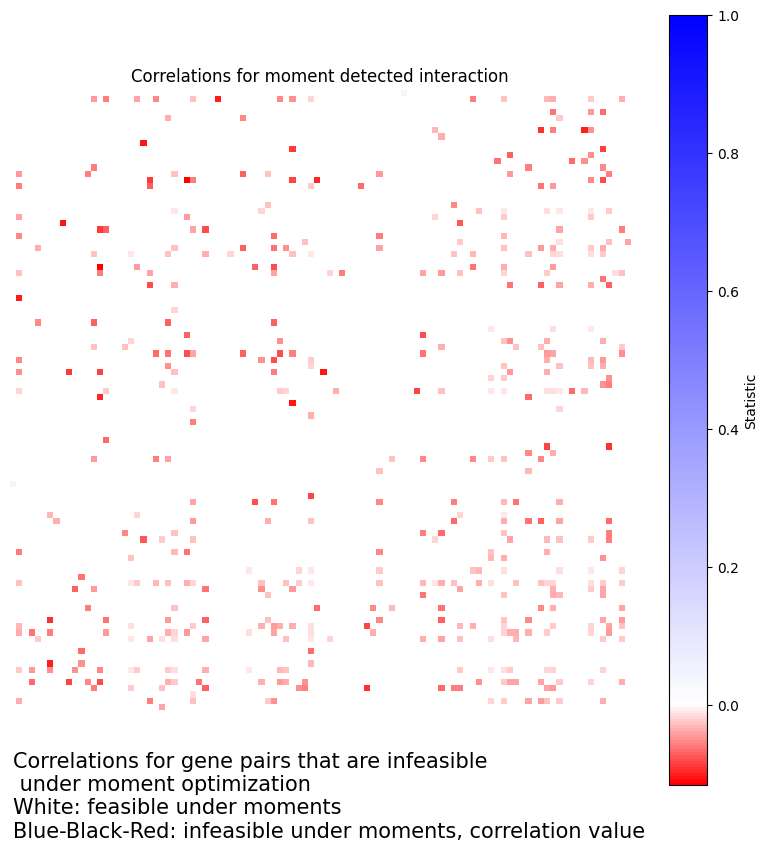

In [229]:
fig, axs = plt.subplots(figsize=(10, 10))
vmin = -0.11555257182978498 #np.nanmin(moment_blackout_array)
vmax = 1 #np.nanmax(moment_blackout_array)
cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (-vmin / (vmax - vmin), "w"), (1, "b")], N=256)
img = axs.imshow(moment_blackout_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Correlations for moment detected interaction")
plt.axis('off')
plt.text(0.0, 120.0, 
         "Correlations for gene pairs that are infeasible \n under moment optimization\
         \nWhite: feasible under moments \
         \nBlue-Black-Red: infeasible under moments, correlation value",
         size=15)
cbar = plt.colorbar(img, ax=axs)
cbar.set_label("Statistic")

#### Correlation of moment-feasible pairs

In [235]:
import scipy

moment_whiteout_array = np.zeros((genes, genes))
k = 0
for i in range(genes):
    for j in range(genes):
        if j > i:
            pass
        else:
            if moment_array[i, j] == 0:
                # change feasible pairs value to correlation

                # get sample
                sample = moment_FIB.dataset.count_dataset.loc[f'Gene-pair-{k}']
                x1_sample = [x[0] for x in sample]
                x2_sample = [x[1] for x in sample]

                # correlation test
                pearson = scipy.stats.pearsonr(x1_sample, x2_sample, alternative='less')

                # store statistic
                moment_whiteout_array[i, j] = float(pearson.statistic)

            else:
                # set infeasible pairs to 0
                moment_whiteout_array[i, j] = None
            k += 1

# fill above diagonal by symmetry
for i in range(genes):
    for j in range(genes):
        if j > i:
            moment_whiteout_array[i, j] = moment_whiteout_array[j, i]

# optional delete diagonal
for k in range(genes):
    moment_whiteout_array[k, k] = None

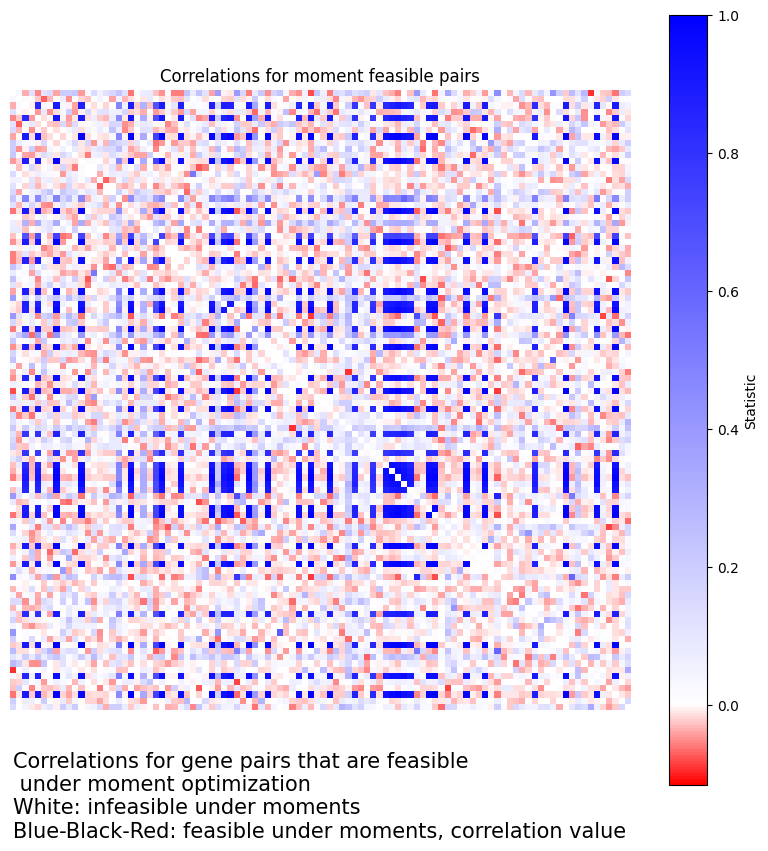

In [236]:
fig, axs = plt.subplots(figsize=(10, 10))
vmin = -0.11555257182978498 #np.nanmin(moment_blackout_array)
vmax = 1 #np.nanmax(moment_blackout_array)
cmap = LinearSegmentedColormap.from_list('br', [(0, "r"), (-vmin / (vmax - vmin), "w"), (1, "b")], N=256)
img = axs.imshow(moment_whiteout_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Correlations for moment feasible pairs")
plt.axis('off')
plt.text(0.0, 120.0, 
         "Correlations for gene pairs that are feasible \n under moment optimization\
         \nWhite: infeasible under moments \
         \nBlue-Black-Red: feasible under moments, correlation value",
         size=15)
cbar = plt.colorbar(img, ax=axs)
cbar.set_label("Statistic")

### Independent Birth-Death optimization

In [139]:
dataset_FIB.bootstrap_marginal_fm(tqdm_disable=False)

100%|██████████| 5050/5050 [01:03<00:00, 79.51it/s] 


In [140]:
dataset_FIB.bootstrap_marginal_probabilities(tqdm_disable=False)

100%|██████████| 5050/5050 [01:11<00:00, 70.63it/s] 


In [141]:
# optimization analysis
indep_BD_FIB = optimization.Optimization(
    dataset_FIB,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_probability_2",
        "downsampled_marginal_CME_1",
        "downsampled_marginal_CME_2",
        "k_deg_1",
        "k_deg_2"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

 41%|████      | 2065/5050 [45:42<190:50:27, 230.16s/it]Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment_parameters) as env:
  File "src\\gurobipy\\env.pxi", line 88, in gurobipy._core.Env.__init__
gurobipy._exception.GurobiError: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
 41%|████      | 2066/5050 [45:42<133:35:00, 161.16s/it]

Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment_parameters) as env:
  File "src\\gurobipy\\env.pxi", line 88, in gurobipy._core.Env.__init__
gurobipy._exception.GurobiError: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
 41%|████      | 2067/5050 [45:43<93:39:03, 113.02s/it] 

Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment_parameters) as env:
  File "src\\gurobipy\\env.pxi", line 88, in gurobipy._core.Env.__init__
gurobipy._exception.GurobiError: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
 41%|████      | 2068/5050 [45:43<65:35:43, 79.19s/it] Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", l

Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment_parameters) as env:
  File "src\\gurobipy\\env.pxi", line 88, in gurobipy._core.Env.__init__
gurobipy._exception.GurobiError: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment

Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment_parameters) as env:
  File "src\\gurobipy\\env.pxi", line 88, in gurobipy._core.Env.__init__
gurobipy._exception.GurobiError: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment

Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment_parameters) as env:
  File "src\\gurobipy\\env.pxi", line 88, in gurobipy._core.Env.__init__
gurobipy._exception.GurobiError: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment

Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment_parameters) as env:
  File "src\\gurobipy\\env.pxi", line 88, in gurobipy._core.Env.__init__
gurobipy._exception.GurobiError: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment

Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment_parameters) as env:
  File "src\\gurobipy\\env.pxi", line 88, in gurobipy._core.Env.__init__
gurobipy._exception.GurobiError: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment

Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)


 67%|██████▋   | 3400/5050 [8:43:55<1031:10:38, 2249.84s/it]Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment_parameters) as env:
  File "src\\gurobipy\\env.pxi", line 88, in gurobipy._core.Env.__init__
gurobipy._exception.GurobiError: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
 67%|██████▋   | 3401/5050 [8:43:55<869:11:49, 1897.58s/it] 

GurobiError
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)


Traceback (most recent call last):


Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)


  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment_parameters) as env:
  File "src\\gurobipy\\env.pxi", line 88, in gurobipy._core.Env.__init__
gurobipy._exception.GurobiError: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment_parameters) as env:
  File "src\\g

Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment_parameters) as env:
  File "src\\gurobipy\\env.pxi", line 88, in gurobipy._core.Env.__init__
gurobipy._exception.GurobiError: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment

Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 85, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 121, in optimize
    with gp.Env(params=environment_parameters) as env:
  File "src\\gurobipy\\env.pxi", line 88, in gurobipy._core.Env.__init__
gurobipy._exception.GurobiError: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)
 67%|██████▋   | 3406/5050 [8:43:56<340:49:26, 746.33s/it]

Optimization failed: Could not resolve host: token.gurobi.com (code 6, command POST https://token.gurobi.com/api/v1/tokens)


 77%|███████▋  | 3891/5050 [9:00:22<2:40:57,  8.33s/it]   


KeyboardInterrupt: 

In [ ]:
indep_BD_array = np.zeros((genes, genes))
k = 0
for i in range(genes):
    for j in range(genes):
        # ignore above diagonal
        if j > i:
            pass
        else:
            if indep_BD_FIB.result_dict[k]['status'] == "INFEASIBLE":
                indep_BD_array[i, j] = 1
            elif indep_BD_FIB.result_dict[k]['status'] == "OPTIMAL":
                indep_BD_array[i, j] = 0
            else:
                indep_BD_array[i, j] = 0.5
            k += 1

# fill above diagonal by symmetry
for i in range(genes):
    for j in range(genes):
        if j > i:
            indep_BD_array[i, j] = indep_BD_array[j, i]

# optional remove lower triangle + diagonal (as symmetric + irrelevant diag)
#for i in range(genes):
#    for j in range(genes):
#        if j <= i:
#            moment_array[i, j] = 0.5

Text(0.0, 110.0, 'Optimization using marginal prob. CIs         \nBlue: feasible, independent birth-death pair          \nRed: infeasible          \nWhite: optimization failure')

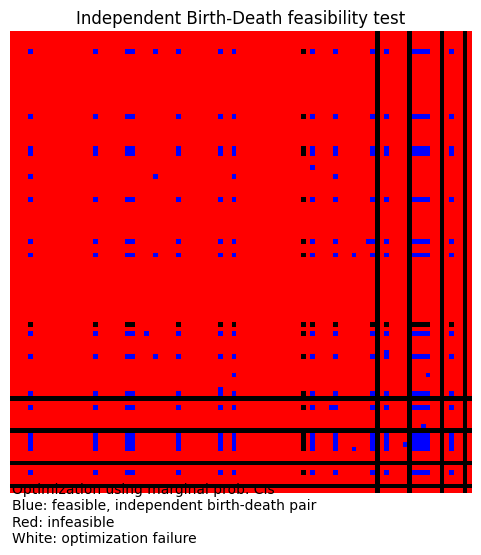

In [ ]:
fig, axs = plt.subplots(figsize=(6, 6))
cmap = LinearSegmentedColormap.from_list('br', [(0, "b"), (0.5, "k"), (1, "r")], N=256)
vmin, vmax = 0, 1
img = axs.imshow(indep_BD_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Independent Birth-Death feasibility test")
plt.axis('off')
plt.text(0.0, 110.0, "Optimization using marginal prob. CIs\
         \nBlue: feasible, independent birth-death pair \
         \nRed: infeasible \
         \nWhite: optimization failure")

#### Why does this not agree with individual sample birth death feasibility tests?

## Interacting BD feasibility tests

In [ ]:
# optimization analysis
int_BD_FIB = optimization.Optimization(
    dataset_FIB,
    [
        "downsampled_probability",
        "downsampled_CME",
        "k_deg_1"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

## Indep TE feasibility tests

In [ ]:
# optimization analysis
indep_TE_FIB = optimization.Optimization(
    dataset_FIB,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_probability_2",
        "downsampled_marginal_CME_TE_1",
        "downsampled_marginal_CME_TE_2",
        "downsampled_marginal_TE_link_1",
        "downsampled_marginal_TE_link_2",
        "k_deg_1",
        "k_deg_2"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

## Construct dataset single genes (paired to save space)

i.e. (X1, X2), (X3, X4), ... 

for marginal optimization

In [118]:
# size
genes = 100
gene_pairs = genes // 2
cells = data_FIB.shape[1]

# construct paired count dataframe
counts_df = pd.DataFrame(
    index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
    columns = [f"Cell-{j}" for j in range(cells)]
)

# fill with pairs
i = 0
for k in range(gene_pairs):
    gene_i = data_FIB.iloc[i]
    gene_j = data_FIB.iloc[i + 1]
    gene_pair_ij = list(zip(gene_i, gene_j))
    counts_df.iloc[k] = gene_pair_ij
    i += 2

# construct object
dataset_single_FIB = dataset.Dataset("dataset_single_FIB")
dataset_single_FIB.count_dataset = counts_df
dataset_single_FIB.cells = cells
dataset_single_FIB.gene_pairs = gene_pairs

# settings
dataset_single_FIB.thresh_OB = 3
dataset_single_FIB.threshM_OB = 3

# set capture
dataset_single_FIB.beta = BETA

### Marginal optimization

In [119]:
# memory details
dataset_single_FIB.resamples = 1000

In [120]:
dataset_single_FIB.bootstrap_marginal_probabilities(tqdm_disable=False)

100%|██████████| 50/50 [00:00<00:00, 57.52it/s]


In [121]:
dataset_single_FIB.bootstrap_marginal_fm(tqdm_disable=False)

100%|██████████| 50/50 [00:00<00:00, 70.71it/s]


### Birth-Death

In [107]:
# optimization analysis (for genes i = 0, 2, ...)
even_results_BD = optimization.Optimization(
    dataset_single_FIB,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_CME_1",
        "k_deg_1"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


In [108]:
# optimization analysis (for genes i = 1, 3, ...)
odd_results_BD = optimization.Optimization(
    dataset_single_FIB,
    [
        "downsampled_marginal_probability_2",
        "downsampled_marginal_CME_2",
        "k_deg_2"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

100%|██████████| 50/50 [05:06<00:00,  6.13s/it]


In [109]:
# combine results of feasibility test
feasible_results_BD = []
for k in range(gene_pairs):
    feasible_results_BD.append(even_results_BD.result_dict[k]['status'])
    feasible_results_BD.append(odd_results_BD.result_dict[k]['status'])

21 Feasible 
78 Infeasible


Text(0.5, 1.0, 'Independent Birth-Death feasiblity tests')

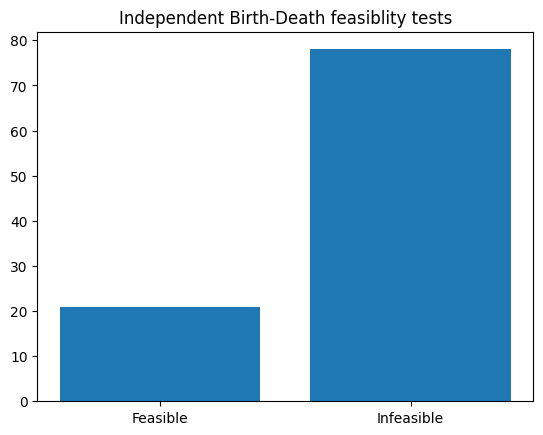

In [110]:
num_feasible = (np.array(feasible_results_BD) == 'OPTIMAL').sum()
num_infeasible = (np.array(feasible_results_BD) == 'INFEASIBLE').sum()

print(f"{num_feasible} Feasible \n{num_infeasible} Infeasible")

plt.bar(["Feasible", "Infeasible"], [num_feasible, num_infeasible]);
plt.title("Independent Birth-Death feasiblity tests")

In [113]:
indep_BD_array_sep = np.zeros((genes, genes))
for i in range(genes):
    for j in range(genes):

        # get feasibility results
        gene_i = feasible_results_BD[i]
        gene_j = feasible_results_BD[j]

        if gene_i == "OPTIMAL" and gene_j == "OPTIMAL":
            indep_BD_array_sep[i, j] = 0
        elif gene_i == "INFEASIBLE" and gene_j == "INFEASIBLE":
            indep_BD_array_sep[i, j] = 1
        elif gene_i == "INFEASIBLE" and gene_j == "OPTIMAL":
            indep_BD_array_sep[i, j] = 0.75
        elif gene_i == "OPTIMAL" and gene_j == "INFEASIBLE":
            indep_BD_array_sep[i, j] = 0.75
        else:
            indep_BD_array_sep[i, j] = 0.5
# optional remove lower triangle + diagonal (as symmetric + irrelevant diag)
#for i in range(genes):
#    for j in range(genes):
#        if j <= i:
#            moment_array[i, j] = 0.5

Text(0.0, 120.0, 'Optimization using marginal prob. CIs          \nBlue: both genes feasible, independent birth-death pair          \nRed: both genes infeasible          \nYellow: one gene infeasible, one optimal          \nWhite: optimization failure')

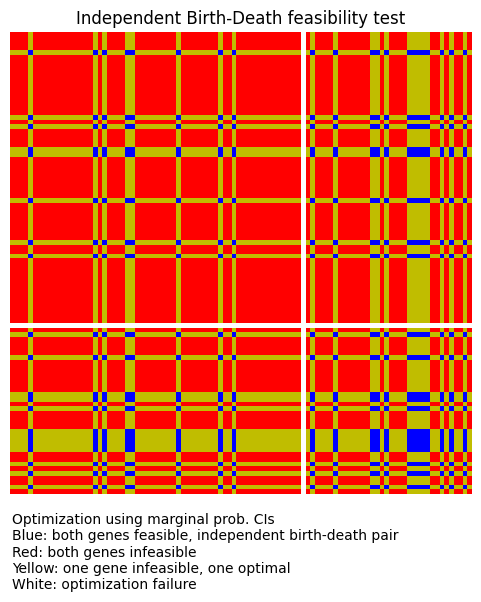

In [114]:
fig, axs = plt.subplots(figsize=(6, 6))
cmap = LinearSegmentedColormap.from_list('br', [(0, "b"), (0.5, "w"), (0.75, "y"), (1, "r")], N=256)
vmin, vmax = 0, 1
img = axs.imshow(indep_BD_array_sep, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Independent Birth-Death feasibility test")
plt.axis('off')
plt.text(0.0, 120.0, "Optimization using marginal prob. CIs \
         \nBlue: both genes feasible, independent birth-death pair \
         \nRed: both genes infeasible \
         \nYellow: one gene infeasible, one optimal \
         \nWhite: optimization failure")

### Telegraph

In [122]:
# optimization analysis (for genes i = 0, 2, ...)
even_results_TE = optimization.Optimization(
    dataset_single_FIB,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_CME_TE_1",
        "downsampled_marginal_TE_link_1",
        "k_deg_1"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

100%|██████████| 50/50 [05:23<00:00,  6.48s/it]


In [123]:
# optimization analysis (for genes i = 1, 3, ...)
odd_results_TE = optimization.Optimization(
    dataset_single_FIB,
    [
        "downsampled_marginal_probability_2",
        "downsampled_marginal_CME_TE_2",
        "downsampled_marginal_TE_link_2",
        "k_deg_2"
    ],
    tqdm_disable=False,
    print_solution=False,
    license_file="C:/WLS_credentials.json"
)

100%|██████████| 50/50 [00:14<00:00,  3.53it/s]


In [124]:
# combine results of feasibility test
feasible_results_TE = []
for k in range(gene_pairs):
    feasible_results_TE.append(even_results_TE.result_dict[k]['status'])
    feasible_results_TE.append(odd_results_TE.result_dict[k]['status'])

99 Feasible 
0 Infeasible


Text(0.5, 1.0, 'Independent Telegraph feasiblity tests')

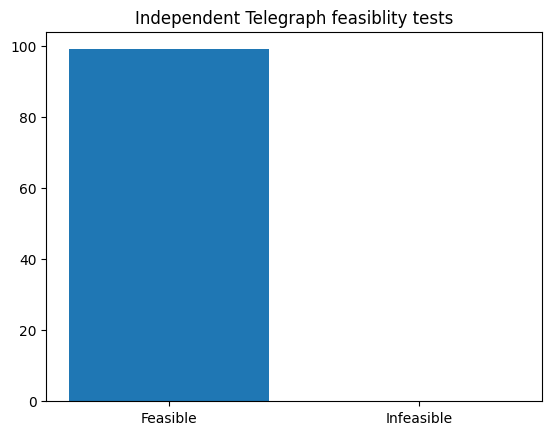

In [125]:
num_feasible = (np.array(feasible_results_TE) == 'OPTIMAL').sum()
num_infeasible = (np.array(feasible_results_TE) == 'INFEASIBLE').sum()

print(f"{num_feasible} Feasible \n{num_infeasible} Infeasible")

plt.bar(["Feasible", "Infeasible"], [num_feasible, num_infeasible]);
plt.title("Independent Telegraph feasiblity tests")

In [126]:
indep_TE_array_sep = np.zeros((genes, genes))
for i in range(genes):
    for j in range(genes):

        # get feasibility results
        gene_i = feasible_results_TE[i]
        gene_j = feasible_results_TE[j]

        if gene_i == "OPTIMAL" and gene_j == "OPTIMAL":
            indep_TE_array_sep[i, j] = 0
        elif gene_i == "INFEASIBLE" and gene_j == "INFEASIBLE":
            indep_TE_array_sep[i, j] = 1
        elif gene_i == "INFEASIBLE" and gene_j == "OPTIMAL":
            indep_TE_array_sep[i, j] = 0.75
        elif gene_i == "OPTIMAL" and gene_j == "INFEASIBLE":
            indep_TE_array_sep[i, j] = 0.75
        else:
            indep_TE_array_sep[i, j] = 0.5
# optional remove lower triangle + diagonal (as symmetric + irrelevant diag)
#for i in range(genes):
#    for j in range(genes):
#        if j <= i:
#            moment_array[i, j] = 0.5

Text(0.0, 120.0, 'Optimization using marginal prob. CIs          \nBlue: both genes feasible, independent telegraph pair          \nRed: both genes infeasible          \nYellow: one gene infeasible, one optimal          \nWhite: optimization failure')

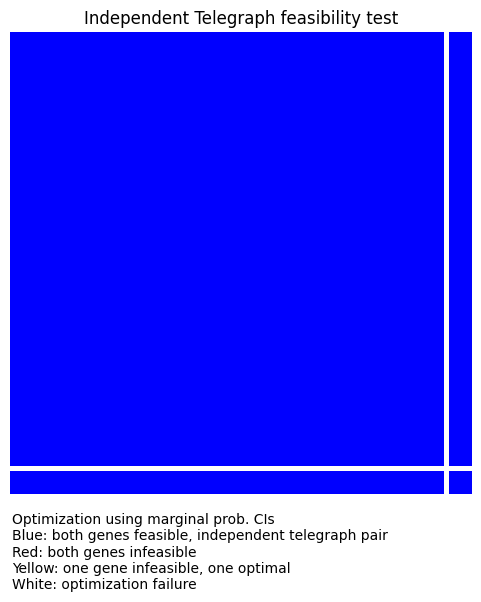

In [127]:
fig, axs = plt.subplots(figsize=(6, 6))
cmap = LinearSegmentedColormap.from_list('br', [(0, "b"), (0.5, "w"), (0.75, "y"), (1, "r")], N=256)
vmin, vmax = 0, 1
img = axs.imshow(indep_TE_array_sep, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Independent Telegraph feasibility test")
plt.axis('off')
plt.text(0.0, 120.0, "Optimization using marginal prob. CIs \
         \nBlue: both genes feasible, independent telegraph pair \
         \nRed: both genes infeasible \
         \nYellow: one gene infeasible, one optimal \
         \nWhite: optimization failure")

### Optimization 'failure'

Occurs when truncation of a sample is [0, 0] because no states except x = 0 are observed more than thresh number of times (e.g. 3) e.g. Sample below only has one non-zero observed count of x = 1750

This means no CME equations can be used as constraints, as equations involve at least 2 states but bounds only exist on 1.

To solve we can artificially increase the truncation for these samples to [0, 1] (at least, possibly larger) by adding uninformative bounds (i.e. [0, 1]), but suggests a larger problem at hand

{'minM_x1_OB': 1, 'maxM_x1_OB': 14, 'minM_x2_OB': 0, 'maxM_x2_OB': 0}

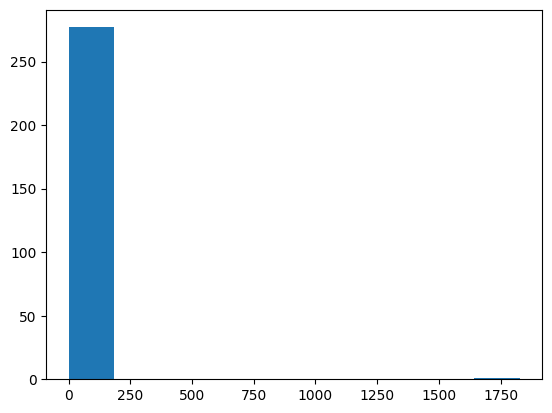

In [151]:
plt.hist([x[1] for x in dataset_single_FIB.count_dataset.loc[f'Gene-pair-{9}']])
dataset_single_FIB.truncationM_OB[f'sample-{0}']

# Sankey plots

In [4]:
import plotly
import plotly.graph_objects as go
import pandas as pd

In [92]:
df = pd.DataFrame(columns=["Test_1", "Test_2", "Test_3"])
df["Test_1"] = [True, True, True, False, False]
df["Test_2"] = [True, True, True, True, True]
df["Test_3"] = [True, False, True, False, 4]
df.head()

,Test_1,Test_2,Test_3
0,True,True,True
1,True,True,False
2,True,True,True
3,False,True,False
4,False,True,4


In [131]:
def sankey_from_df(df):

    column_number = df.shape[1]

    # unique values per column
    column_values = []

    # box indices per column
    column_indices = []

    i = 1
    for col in df.columns:

        values = df[col].unique().tolist()
        column_values.append(values)

        boxes = len(values)
        indices = [x for x in range(i, i + boxes)]
        column_indices.append(indices)

        i += boxes

    # plotting
    source = []
    target = []
    count = []

    # special case for first gap

    # end values
    val_end = column_values[0]

    # end indices
    idx_end = column_indices[0]

    # end column
    col_end = df[df.columns[0]]

    # for each end value
    for val_k, idx_k in zip(val_end, idx_end):

        # get count
        count_k = len(df.loc[col_end == val_k])

        # add link to plot: from 0 to idx with size count
        source.append(0)
        target.append(idx_k)
        count.append(count_k)

    for i in range(column_number - 1):

        # get values
        val_start = column_values[i]
        val_end = column_values[i + 1]

        # get indices
        idx_start = column_indices[i]
        idx_end = column_indices[i + 1]

        # get columns
        col_start = df[df.columns[i]]
        col_end = df[df.columns[i + 1]]

        # for each pair of values level
        for val_j, idx_j in zip(val_start, idx_start):
            for val_k, idx_k in zip(val_end, idx_end):

                # get overlap
                count_jk = len(df.loc[(col_start == val_j) & (col_end == val_k)])

                # add link to plot: from idx_j to idx_k with size count_jk
                source.append(idx_j)
                target.append(idx_k)
                count.append(count_jk)

    # box labels
    labels = [""]
    for values in column_values:
        for val in values:
            labels.append(str(val))

    fig = go.Figure(data=[go.Sankey(
        node = {"label": labels},
        link = {"source": source, "target": target, "value": count, "color": "lightgrey"}
        )])
    fig.update_layout(font_size=15)
    fig.show()

In [95]:
sankey_from_df(df)

## Independent tests plot

In [129]:
indep_df = pd.DataFrame(columns=["BD", "TE"])
indep_df["BD"] = feasible_results_BD
indep_df["TE"] = feasible_results_TE

In [132]:
sankey_from_df(indep_df)